In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix

# Path to ensemble prediction files (adjust if needed)
ensemble_folder = r"C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_DeepLearning\prediction\external"
ensemble_avg_file = os.path.join(ensemble_folder, "ensemble_avg.csv")
ensemble_max_file = os.path.join(ensemble_folder, "ensemble_max.csv")

ensemble_avg = pd.read_csv(ensemble_avg_file)
ensemble_max = pd.read_csv(ensemble_max_file)


# Fixed thresholds from your ROC analysis:
threshold_avg = 0.44553510696    # Optimal threshold for LARS-avg (Youden's index)
threshold_max = 0.67608661151    # Optimal threshold for LARS-max (Youden's index)



In [13]:
# Identify individual model probability columns.
model_prob_cols = [col for col in ensemble_avg.columns if col.startswith("probs_model")]
n_models = len(model_prob_cols)
print("Found individual model probability columns:", model_prob_cols)

# Compute binary predictions using fixed thresholds:
for col in model_prob_cols:
    ensemble_avg[col.replace("probs", "pred")] = (ensemble_avg[col] >= threshold_avg).astype(int)
    ensemble_max[col.replace("probs", "pred")] = (ensemble_max[col] >= threshold_max).astype(int)

# Create lists for the binary prediction columns:
pred_cols_avg = [col.replace("probs", "pred") for col in model_prob_cols]
pred_cols_max = [col.replace("probs", "pred") for col in model_prob_cols]

# Also compute the vote_sum: number of models predicting positive per scan.
ensemble_avg['vote_sum'] = ensemble_avg[pred_cols_avg].sum(axis=1)
ensemble_max['vote_sum'] = ensemble_max[pred_cols_max].sum(axis=1)


Found individual model probability columns: ['probs_model0', 'probs_model1', 'probs_model2', 'probs_model3', 'probs_model4', 'probs_model5', 'probs_model6', 'probs_model7', 'probs_model8', 'probs_model9']


In [9]:
def compute_agreement(df, pred_cols):
    # Count for each scan how many model predictions match the true label.
    correct_counts = np.zeros(len(df))
    for col in pred_cols:
        correct_counts += (df[col] == df['target']).astype(int)
    df['correct_count'] = correct_counts
    df['agreement_rate'] = df['correct_count'] / len(pred_cols)
    df['non_concordance'] = 1 - df['agreement_rate']
    return df

ensemble_avg = compute_agreement(ensemble_avg, pred_cols_avg)
ensemble_max = compute_agreement(ensemble_max, pred_cols_max)

print(f"[LARS-avg] Mean Agreement Rate: {ensemble_avg['agreement_rate'].mean():.3f}")
print(f"[LARS-avg] Mean Non-Concordance: {ensemble_avg['non_concordance'].mean():.3f}")


[LARS-avg] Mean Agreement Rate: 0.827
[LARS-avg] Mean Non-Concordance: 0.173


– A high agreement_rate means most individual models correctly predicted the scan’s label, regardless of what the ensemble prediction is.
– The non_concordance rate quantifies the level of disagreement with ground truth

In [14]:
# Compute standard deviation of continuous probabilities for each scan.
ensemble_avg['prob_std'] = ensemble_avg[model_prob_cols].std(axis=1)
ensemble_max['prob_std'] = ensemble_max[model_prob_cols].std(axis=1)

# Compute binary consistency: fraction of models in agreement with the majority vote.
ensemble_avg['binary_consistency'] = np.where(
    ensemble_avg['vote_sum'] >= n_models/2,
    ensemble_avg['vote_sum'] / n_models,
    (n_models - ensemble_avg['vote_sum']) / n_models
)
ensemble_max['binary_consistency'] = np.where(
    ensemble_max['vote_sum'] >= n_models/2,
    ensemble_max['vote_sum'] / n_models,
    (n_models - ensemble_max['vote_sum']) / n_models
)

print("[LARS-avg] Mean Probability Std: {:.3f}".format(ensemble_avg['prob_std'].mean()))
print("[LARS-avg] Mean Binary Consistency: {:.3f}".format(ensemble_avg['binary_consistency'].mean()))

print("[LARS-max] Mean Probability Std: {:.3f}".format(ensemble_max['prob_std'].mean()))
print("[LARS-max] Mean Binary Consistency: {:.3f}".format(ensemble_max['binary_consistency'].mean()))


[LARS-avg] Mean Probability Std: 0.128
[LARS-avg] Mean Binary Consistency: 0.907
[LARS-max] Mean Probability Std: 0.178
[LARS-max] Mean Binary Consistency: 0.890


In [15]:
# Define thresholds for high disagreement. For example, flag scans with binary_consistency < 0.6.
low_consistency_threshold = 0.6
disagreement_scans_avg = ensemble_avg[ensemble_avg['binary_consistency'] < low_consistency_threshold]
disagreement_scans_max = ensemble_max[ensemble_max['binary_consistency'] < low_consistency_threshold]

print(f"Number of scans with binary consistency < {low_consistency_threshold} (LARS-avg): {len(disagreement_scans_avg)}")
print("Scan IDs and metrics (LARS-avg):")
print(disagreement_scans_avg[['scan_id', 'vote_sum', 'binary_consistency', 'prob_std']])

# Optionally, you can also flag cases using the top quartile of prob_std.
high_std_threshold = ensemble_avg['prob_std'].quantile(0.75)
high_std_scans_avg = ensemble_avg[ensemble_avg['prob_std'] >= high_std_threshold]
print(f"\nNumber of scans with prob_std >= {high_std_threshold:.3f} (LARS-avg): {len(high_std_scans_avg)}")
print("Scan IDs and metrics (LARS-avg):")
print(high_std_scans_avg[['scan_id', 'vote_sum', 'binary_consistency', 'prob_std']])


Number of scans with binary consistency < 0.6 (LARS-avg): 9
Scan IDs and metrics (LARS-avg):
     scan_id  vote_sum  binary_consistency  prob_std
104      523         5                 0.5  0.288084
142      716         5                 0.5  0.319709
197      846         5                 0.5  0.222378
253     1242         5                 0.5  0.282281
259     1251         5                 0.5  0.180114
299     1549         5                 0.5  0.273778
315     1646         5                 0.5  0.250941
329     1713         5                 0.5  0.233014
332     1723         5                 0.5  0.212959

Number of scans with prob_std >= 0.209 (LARS-avg): 87
Scan IDs and metrics (LARS-avg):
     scan_id  vote_sum  binary_consistency  prob_std
8         74         4                 0.6  0.292099
12        86         7                 0.7  0.230686
14        93         1                 0.9  0.291801
15        98         2                 0.8  0.243367
16        99         4  

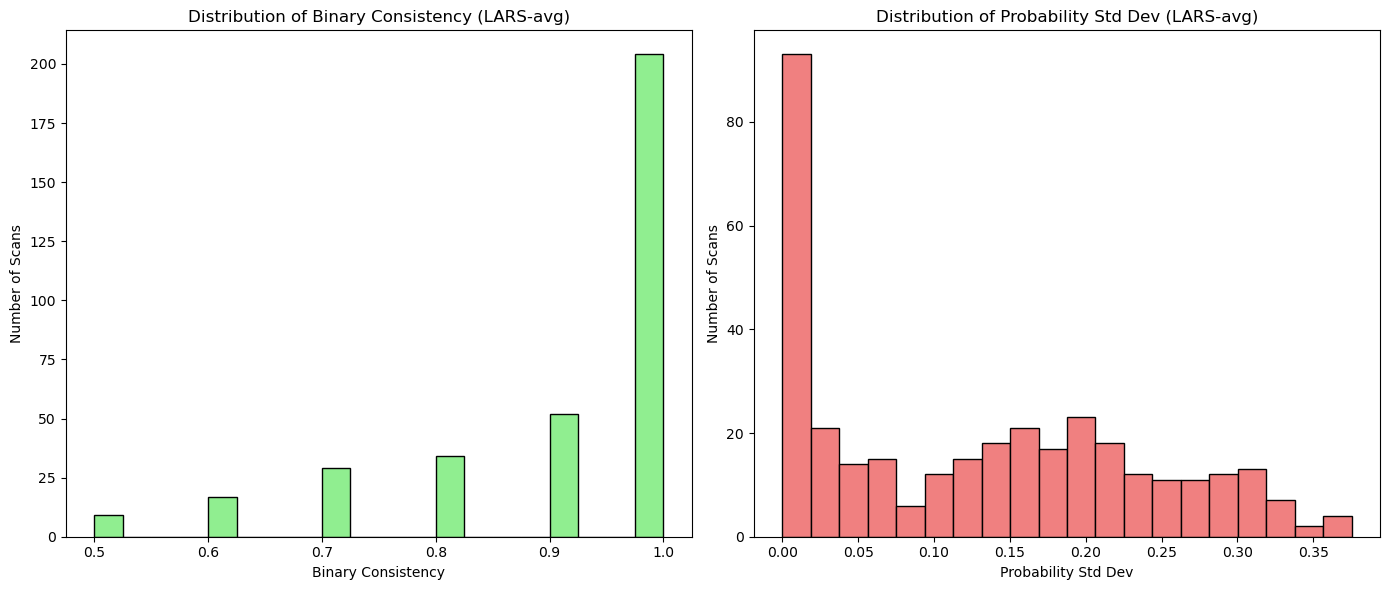

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(ensemble_avg['binary_consistency'], bins=20, color='lightgreen', edgecolor='k')
plt.xlabel("Binary Consistency")
plt.ylabel("Number of Scans")
plt.title("Distribution of Binary Consistency (LARS-avg)")

plt.subplot(1, 2, 2)
plt.hist(ensemble_avg['prob_std'], bins=20, color='lightcoral', edgecolor='k')
plt.xlabel("Probability Std Dev")
plt.ylabel("Number of Scans")
plt.title("Distribution of Probability Std Dev (LARS-avg)")

plt.tight_layout()
plt.show()


   ensemble_size  mean_auc  mean_acc
0              2  0.900363  0.863478
1              3  0.903494  0.856232
2              4  0.907301  0.862899
3              5  0.910006  0.870725
4              6  0.910056  0.879275
5              7  0.911503  0.871884
6              8  0.911930  0.883043
7              9  0.911363  0.877536
8             10  0.911111  0.892754


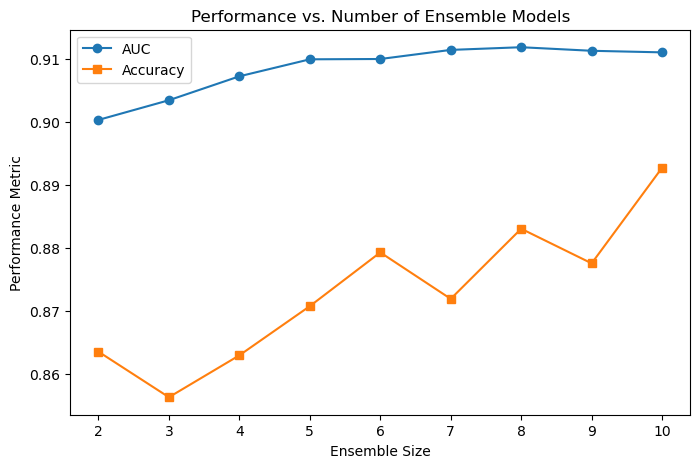

In [17]:
from sklearn.metrics import roc_auc_score, accuracy_score

def evaluate_subensemble(df, model_indices, threshold):
    cols = [f'probs_model{i}' for i in model_indices]
    subensemble_prob = df[cols].median(axis=1)
    pred_label = (subensemble_prob >= threshold).astype(int)
    auc = roc_auc_score(df['target'], subensemble_prob)
    acc = accuracy_score(df['target'], pred_label)
    return auc, acc

ensemble_size_range = range(2, n_models + 1)
performance = []

# For each ensemble size, sample 20 random combinations and average the metrics.
for size in ensemble_size_range:
    aucs, accs = [], []
    for combo in [np.random.choice(n_models, size, replace=False) for _ in range(20)]:
        auc, acc = evaluate_subensemble(ensemble_avg, combo, threshold_avg)
        aucs.append(auc)
        accs.append(acc)
    performance.append({
        'ensemble_size': size,
        'mean_auc': np.mean(aucs),
        'mean_acc': np.mean(accs)
    })

perf_df = pd.DataFrame(performance)
print(perf_df)

plt.figure(figsize=(8, 5))
plt.plot(perf_df['ensemble_size'], perf_df['mean_auc'], marker='o', label="AUC")
plt.plot(perf_df['ensemble_size'], perf_df['mean_acc'], marker='s', label="Accuracy")
plt.xlabel("Ensemble Size")
plt.ylabel("Performance Metric")
plt.title("Performance vs. Number of Ensemble Models")
plt.legend()
plt.show()
